<a href="https://colab.research.google.com/github/TentaTonny/WhereIsWaldo_Team18/blob/main/whereIsWaldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path = '/content/gdrive/MyDrive/Hey-Waldo/'

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
dataset_64 = datasets.ImageFolder(f'{data_path}64', transform=transform)
dataset_128 = datasets.ImageFolder(f'{data_path}128', transform=transform)

# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([dataset_64, dataset_128])

# Create a dataloader
train_loader = DataLoader(combined_dataset, batch_size=10, shuffle=True)

<ipython-input-5-ec3eb3415d1c>:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(img.T, cmap="gray")


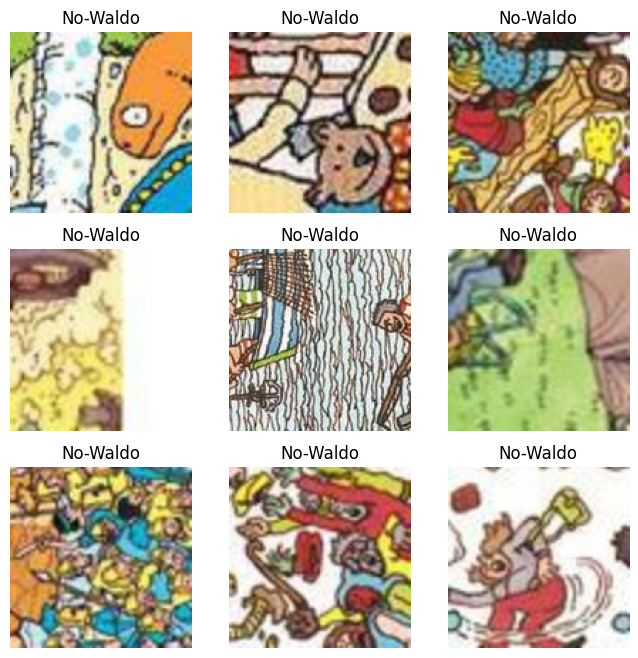

In [5]:
test_loader = DataLoader(combined_dataset, batch_size=9, shuffle=True)
train_features, train_labels = next(iter(test_loader))

labels_map = {
    0: "No-Waldo",
    1: "Waldo",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(len(train_features)):
    img, label = train_features[i], train_labels[i]
    figure.add_subplot(rows, cols, (i + 1))
    plt.title(labels_map[label.item()])
    plt.axis("off")
    plt.imshow(img.T, cmap="gray")
plt.show()

In [6]:
labels = []
for i in range(len(combined_dataset)):
  labels.append(combined_dataset[i][1]) #add label as int

KeyboardInterrupt: ignored

In [7]:
print(f'# images containing Waldo {labels.count(1)}')
print(f'# images not containing Waldo {labels.count(0)}')
print(f'# images in total {len(labels)}')

# images containing Waldo 0
# images not containing Waldo 46
# images in total 46


Pre-Train the model using a triplet loss

In [8]:
class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
         # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

In [9]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out

In [11]:
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

In [12]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        x = self.classifier(x)
        return x

**Data Pre-Processing**

In [13]:
transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.ToTensor()
                                      ])
#Mss hebben we andere transformers nodig voor de verschillende sets?

In [14]:
# Load datasets
dataset_64 = datasets.ImageFolder(f'{data_path}64', transform=transform_train)
dataset_128 = datasets.ImageFolder(f'{data_path}128', transform=transform_train)

# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([dataset_64, dataset_128])

In [15]:
from torch.utils.data import DataLoader

# Calculate the sizes for train, validation, and test sets
total_data = len(combined_dataset)
train_val_size = int(0.9 * total_data)
test_size = total_data - train_val_size

# Splitting combined_dataset into train_val_set and test_set
train_val_set, test_set = torch.utils.data.random_split(combined_dataset, [train_val_size, test_size])

# Further splitting train_val_set into train_set and validation_set
train_size = int(0.9 * len(train_val_set))
val_size = len(train_val_set) - train_size
train_set, validation_set = torch.utils.data.random_split(train_val_set, [train_size, val_size])

# Creating DataLoader for each dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)


In [16]:
classes = ('Not_waldo', 'Waldo')

def imshow(inp):
    """Display image from a PyTorch Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    return inp

In [17]:
# get some random training images
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

#[Batch-size, channels, Hight?, width?]

torch.Size([128, 3, 128, 128])
torch.Size([128])


In [18]:
# let's have a look at the labels for the first 4 loaded images
print(labels[:4])
# if we would like to map them to human-readble text labels
print(', '.join([classes[labels[b]] for b in range(4)]))

tensor([0, 0, 0, 0])
Not_waldo, Not_waldo, Not_waldo, Not_waldo


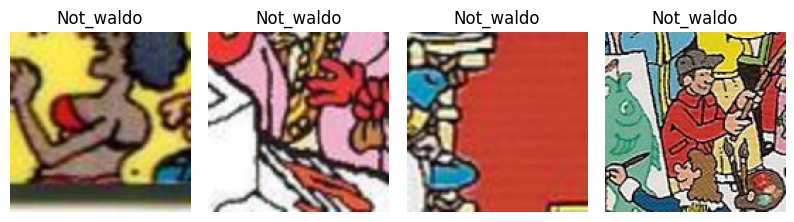

In [19]:
num_images_to_show = 4
fig, axs = plt.subplots(1, num_images_to_show, figsize=(10,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)

for j in range(num_images_to_show):
    axs[j].imshow(imshow(images[j]))
    axs[j].set_title(classes[labels[j].item()])

plt.subplots_adjust(wspace=0.1, hspace = 0)

In [20]:
model = ViT(image_size = 128,
            patch_size = 4,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

random_input = torch.randn(1,3,128,128).to(device)
print(model(random_input).shape)

torch.Size([1, 2])


In [21]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss()

In [22]:
print_every = 200
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        epoch_loss = train_loss/(batch_idx+1)
        epoch_acc = 100.*correct/total

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, len(train_loader),
                                                                                   epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [23]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    print('Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(acc, loss))
    return acc

In [ ]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    scheduler.step()
    acc = test()
    state = {'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch}
    if acc > best_acc:
        torch.save(state, 'model.pth')
        best_acc = acc

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('train loss')

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('train accuracy')